In [39]:
import os
import re
import json
import math
import pandas as pd

EMAILS_PATH = r"./Scripts/data_clean/Emails_clean_9902.parquet"
TAXONOMY_PATHS = ["./Scripts/risk_analysis/RiskTaxonomy.json"] 
OUTPUT_PATH = "EnhancedRiskScores.parquet"


if not os.path.exists(EMAILS_PATH):
    raise FileNotFoundError(f"Emails file not found: {EMAILS_PATH}")

emails = pd.read_parquet(EMAILS_PATH)


tax_path = None
for p in TAXONOMY_PATHS:
    if os.path.exists(p):
        tax_path = p
        break
if tax_path is None:
    raise FileNotFoundError(f"Could not find a taxonomy file. Tried: {TAXONOMY_PATHS}")

with open(tax_path, "r", encoding="utf-8") as f:
    taxonomy_raw = json.load(f)


def build_category_keyword_map(tax):
    cat_to_kw = {}
    if isinstance(tax, dict) and "categories" in tax and isinstance(tax["categories"], list):
        for cat in tax["categories"]:
            cat_name = cat.get("name", "").strip()
            all_kw = []
            for sub in cat.get("subcategories", []):
                kws = sub.get("keywords", [])
                if isinstance(kws, list):
                    all_kw.extend(kws)
            if cat_name and all_kw:
                cat_to_kw[cat_name] = all_kw
    else:
        if isinstance(tax, list):
            for item in tax:
                cat_name = item.get("category") or item.get("name")
                kws = item.get("sample_keywords") or item.get("keywords", [])
                if cat_name and isinstance(kws, list) and kws:
                    cat_to_kw[cat_name] = kws
    return cat_to_kw

cat_keywords = build_category_keyword_map(taxonomy_raw)
if not cat_keywords:
    raise ValueError("No categories/keywords could be parsed from taxonomy file.")


compiled = {}
for cat, kw_list in cat_keywords.items():
    patterns = []
    for pat in kw_list:
        try:
            patterns.append(re.compile(pat, flags=re.IGNORECASE))
        except re.error as e:

            pass
    if patterns:
        compiled[cat] = patterns

if not compiled:
    raise ValueError("No valid regex patterns compiled from taxonomy.")


TEXT_CANDIDATES = ["body_raw", "body_text", "clean_text", "text", "body", "content"]


text_col = next((c for c in TEXT_CANDIDATES if c in emails.columns), None)
if text_col is None:
    raise KeyError(f"Could not find an email text column. Looked for: {TEXT_CANDIDATES}")


USE_SUBJECT = "subject" in emails.columns

def get_email_text(row):
    body = row.get(text_col, "")
    if not isinstance(body, str):
        body = "" if body is None else str(body)
    if USE_SUBJECT:
        subj = row.get("subject", "")
        if not isinstance(subj, str):
            subj = "" if subj is None else str(subj)
        # simple join; adjust if you want subject excluded
        return (subj + " " + body).strip()
    return body


def count_keyword_hits(text, patterns):
    """Return (total_hits, unique_keyword_hits)."""
    if not isinstance(text, str):
        return 0, 0
    total = 0
    unique = 0
    for pat in patterns:
        matches = pat.findall(text)
        if matches:
            unique += 1
            if isinstance(matches[0], tuple):
                total += sum(1 for _ in matches)
            else:
                total += len(matches)
    return total, unique

def keyword_score(total_hits):
    return min(total_hits / 5.0, 1.0)

def heuristic_model_conf(total_hits, unique_hits, text_len):
    """
    Lightweight 'model' confidence based on:
    - unique keywords found (signals breadth)
    - total hits (signals intensity)
    - mild length normalization to avoid inflating long emails
    Returns 0..1
    """
    if text_len <= 0:
        text_len = 1
    density = min(total_hits / max(text_len / 200.0, 1.0), 3.0) / 3.0  # 0..1
    breadth = min(unique_hits / 4.0, 1.0)  # 0..1
    intensity = min(total_hits / 10.0, 1.0)  # 0..1
    conf = 0.45 * breadth + 0.35 * intensity + 0.20 * density
    return max(0.0, min(conf, 1.0))

records = []
for idx, row in emails.iterrows():
    email_id = row["email_id"]
    txt = get_email_text(row)
    if not isinstance(txt, str):
        txt = str(txt) if txt is not None else ""
    text_len = len(txt.split())

    for cat, patterns in compiled.items():
        total_hits, unique_hits = count_keyword_hits(txt, patterns)
        if total_hits > 0:
            kscore = keyword_score(total_hits)
            mconf  = heuristic_model_conf(total_hits, unique_hits, text_len)
            final  = round((kscore + mconf) / 2.0, 4)

            records.append({
                "email_id": email_id,
                "risk_category": cat,          
                "model_name": "keyword+heuristic", 
                "model_conf": round(mconf, 4),
                "keyword_hits": int(total_hits),
                "final_score": final
            })

enhanced = pd.DataFrame(records)

if enhanced.empty:
    enhanced = pd.DataFrame(columns=["email_id","risk_category","model_name","model_conf","keyword_hits","final_score"])

enhanced.to_parquet(OUTPUT_PATH, index=False)
print(f"✅ Saved {OUTPUT_PATH} with {len(enhanced)} rows.")

if not enhanced.empty:
    display_cols = ["email_id","risk_category","keyword_hits","model_conf","final_score"]
    print("\nTop 5 by final_score:")
    print(enhanced.sort_values("final_score", ascending=False)[display_cols].head(5).to_string(index=False))


✅ Saved EnhancedRiskScores.parquet with 22119 rows.

Top 5 by final_score:
                        email_id risk_category  keyword_hits  model_conf  final_score
d38938073f650b30d6253900ee24491f  reputational            22      0.8700       0.9350
7a5146e858fba2ecab4924e3ba80f67f  reputational            44      0.8673       0.9337
c868c917aae4f1222cc036c4d237cf92    compliance            11      0.8654       0.9327
ce8d0d2259f1ee39fb7b5c040c0050fe  reputational            20      0.8633       0.9316
768e8b73acb274d175a8cf8e951a9e87  reputational            28      0.8530       0.9265


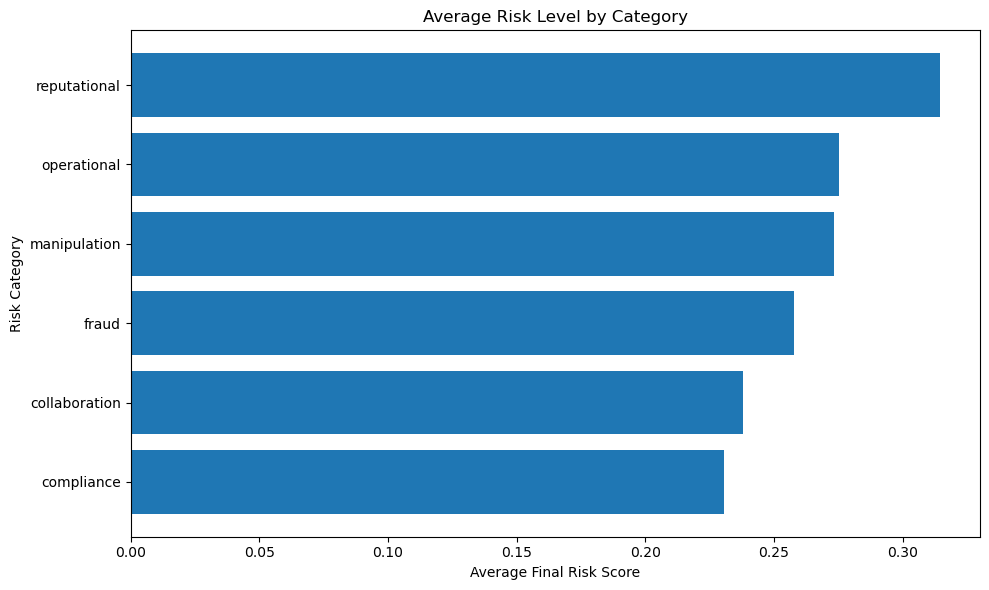

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

enhanced = pd.read_parquet("EnhancedRiskScores.parquet")

cat_summary = (enhanced.groupby("risk_category")
               .agg(avg_score=("final_score", "mean"),
                    total_emails=("email_id", "count"))
               .reset_index()
               .sort_values("avg_score", ascending=False))

plt.figure(figsize=(10,6))
plt.barh(cat_summary["risk_category"], cat_summary["avg_score"])
plt.xlabel("Average Final Risk Score")
plt.ylabel("Risk Category")
plt.title("Average Risk Level by Category")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


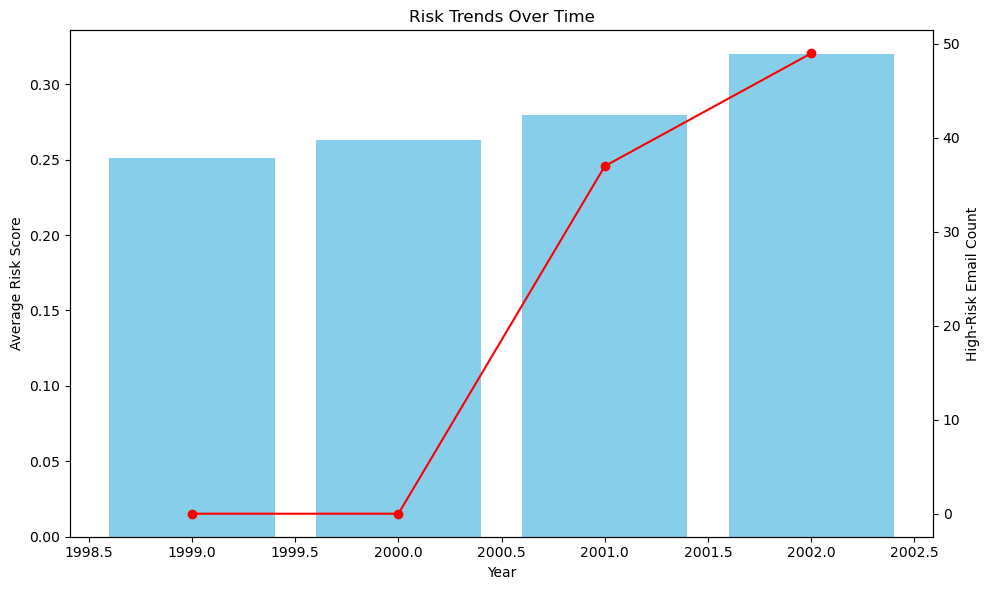

In [47]:
year_summary = (enhanced
                .merge(pd.read_parquet(r"./Scripts\data_clean\Emails_clean_9902.parquet")[["email_id","year"]], on="email_id", how="left")
                .groupby("year")
                .agg(avg_score=("final_score", "mean"),
                     high_risk_count=("final_score", lambda x: (x > 0.9).sum()))
                .reset_index())


fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.bar(year_summary["year"], year_summary["avg_score"], color="skyblue", label="Avg Risk Score")
ax2.plot(year_summary["year"], year_summary["high_risk_count"], color="red", marker="o", label="High-Risk Emails")

ax1.set_xlabel("Year")
ax1.set_ylabel("Average Risk Score")
ax2.set_ylabel("High-Risk Email Count")
plt.title("Risk Trends Over Time")
fig.tight_layout()
plt.show()


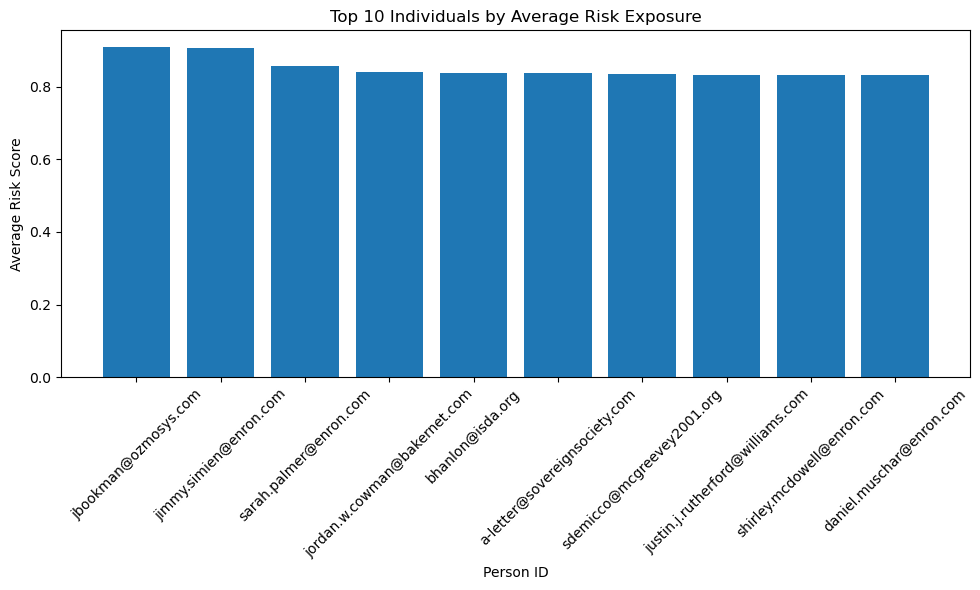

In [49]:
top_senders = (enhanced.groupby("email_id")
               .agg(max_score=("final_score","max"))
               .reset_index()
               .merge(pd.read_parquet(r"./Scripts\data_clean\Emails_clean_9902.parquet")[["email_id","person_id"]], on="email_id", how="left"))

person_summary = (top_senders.groupby("person_id")
                  .agg(avg_risk=("max_score","mean"))
                  .sort_values("avg_risk", ascending=False)
                  .head(10))

plt.figure(figsize=(10,6))
plt.bar(person_summary.index.astype(str), person_summary["avg_risk"])
plt.xlabel("Person ID")
plt.ylabel("Average Risk Score")
plt.title("Top 10 Individuals by Average Risk Exposure")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [57]:
import os, re, json, math
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


EMAILS_PATH = r"./Scripts\data_clean\Emails_clean_9902.parquet"
TAXONOMY_PATHS = ["./Scripts/risk_analysis/RiskTaxonomy.json"]
OUTPUT_PATH = "EnhancedRiskScores.parquet"

if not os.path.exists(EMAILS_PATH):
    raise FileNotFoundError(f"Emails file not found: {EMAILS_PATH}")

emails = pd.read_parquet(EMAILS_PATH)

# Choose text column(s): we’ll use subject + body_raw if available
TEXT_CANDIDATES = ["body_raw", "body_text", "clean_text", "text", "body", "content"]
text_col = next((c for c in TEXT_CANDIDATES if c in emails.columns), None)
if text_col is None:
    raise KeyError(f"Could not find an email text column. Looked for: {TEXT_CANDIDATES}")

USE_SUBJECT = "subject" in emails.columns
if "email_id" not in emails.columns:
    raise KeyError("emails file must contain 'email_id' column.")

def get_email_text(row):
    body = row.get(text_col, "")
    if not isinstance(body, str):
        body = "" if body is None else str(body)
    if USE_SUBJECT:
        subj = row.get("subject", "")
        if not isinstance(subj, str):
            subj = "" if subj is None else str(subj)
        return (subj + " " + body).strip()
    return body

def light_clean(s):
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[-_]{3,}.*$', '', s) 
    return s.strip()

emails["__text__"] = emails.apply(get_email_text, axis=1).map(light_clean)

tax_path = next((p for p in TAXONOMY_PATHS if os.path.exists(p)), None)
if tax_path is None:
    raise FileNotFoundError(f"No taxonomy file found. Tried: {TAXONOMY_PATHS}")

with open(tax_path, "r", encoding="utf-8") as f:
    taxonomy_raw = json.load(f)

def build_category_keyword_map(tax):
    cat_to_kw = {}
    if isinstance(tax, dict) and "categories" in tax:
        for cat in tax["categories"]:
            cat_name = cat.get("name", "").strip()
            all_kw = []
            for sub in cat.get("subcategories", []):
                kws = sub.get("keywords", [])
                if isinstance(kws, list):
                    all_kw.extend(kws)
            if cat_name and all_kw:
                cat_to_kw[cat_name] = all_kw
    elif isinstance(tax, list):  # fallback (flat list)
        for item in tax:
            cat_name = item.get("category") or item.get("name")
            kws = item.get("sample_keywords") or item.get("keywords", [])
            if cat_name and isinstance(kws, list) and kws:
                cat_to_kw[cat_name] = kws
    return cat_to_kw

cat_keywords = build_category_keyword_map(taxonomy_raw)
if not cat_keywords:
    raise ValueError("No categories/keywords parsed from taxonomy.")

compiled = {}
for cat, kw_list in cat_keywords.items():
    pats = []
    for pat in kw_list:
        try:
            pats.append(re.compile(pat, flags=re.IGNORECASE))
        except re.error:
            pass
    if pats:
        compiled[cat] = pats
if not compiled:
    raise ValueError("No valid regex patterns compiled from taxonomy.")

def count_keyword_hits(text, patterns):
    if not isinstance(text, str):
        return 0, 0
    total = 0
    unique = 0
    for pat in patterns:
        m = pat.findall(text)
        if m:
            unique += 1
            if isinstance(m[0], tuple):
                total += sum(1 for _ in m)
            else:
                total += len(m)
    return total, unique

def keyword_score(total_hits):
    return min(total_hits / 5.0, 1.0)


MODEL_NAME = "ProsusAI/finbert"  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
model.eval()

id2label = model.config.id2label  

label2id = {v.lower(): k for k, v in id2label.items()}
NEG_IDX = label2id.get("negative", 1)

@torch.no_grad()
def finbert_negative_prob(texts, batch_size=16, max_length=256):
    """Return list of P(negative) for each text using FinBERT."""
    probs_neg = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1)
        probs_neg.extend(probs[:, NEG_IDX].detach().cpu().tolist())
    return probs_neg

email_texts = emails["__text__"].fillna("").astype(str).tolist()
finbert_neg = finbert_negative_prob(email_texts, batch_size=16, max_length=256)
emails["__finbert_neg__"] = finbert_neg  # risk tone per email (0..1)


records = []
for _, row in emails.iterrows():
    email_id = row["email_id"]
    txt = row["__text__"]
    mconf = float(row["__finbert_neg__"]) 

    for cat, patterns in compiled.items():
        total_hits, unique_hits = count_keyword_hits(txt, patterns)
        if total_hits > 0:
            kscore = keyword_score(total_hits)
            final = round((mconf + kscore) / 2.0, 4)
            records.append({
                "email_id": email_id,
                "risk_category": cat,
                "model_name": "FinBERT(neg-prob)+keywords",
                "model_conf": round(mconf, 4),
                "keyword_hits": int(total_hits),
                "final_score": final
            })

enhanced = pd.DataFrame(records)
if enhanced.empty:
    enhanced = pd.DataFrame(columns=["email_id","risk_category","model_name","model_conf","keyword_hits","final_score"])

enhanced.to_parquet(OUTPUT_PATH, index=False)
print(f"✅ Saved {OUTPUT_PATH} with {len(enhanced)} rows.")

if not enhanced.empty:
    print("\nTop 5 by final_score:")
    print(enhanced.sort_values("final_score", ascending=False)[
        ["email_id","risk_category","keyword_hits","model_conf","final_score"]
    ].head(5).to_string(index=False))


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

C:\Users\Dylan\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Dylan\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

✅ Saved EnhancedRiskScores.parquet with 11723 rows.

Top 5 by final_score:
                        email_id risk_category  keyword_hits  model_conf  final_score
2b6f758f3d324c8d11943c6e323885ba  reputational             5      0.9721       0.9860
8e4952cb3b5bf5153eb884d82aaca744  reputational             5      0.9285       0.9642
20acdbe7ee51b5c3620b800ba5264fe6 collaboration             8      0.9279       0.9640
88bdf85b17833af9dc2d40a06f1f3a62         fraud             7      0.9193       0.9597
3a4933468478356b8fdfe37bd7ba69dd  reputational             7      0.9108       0.9554


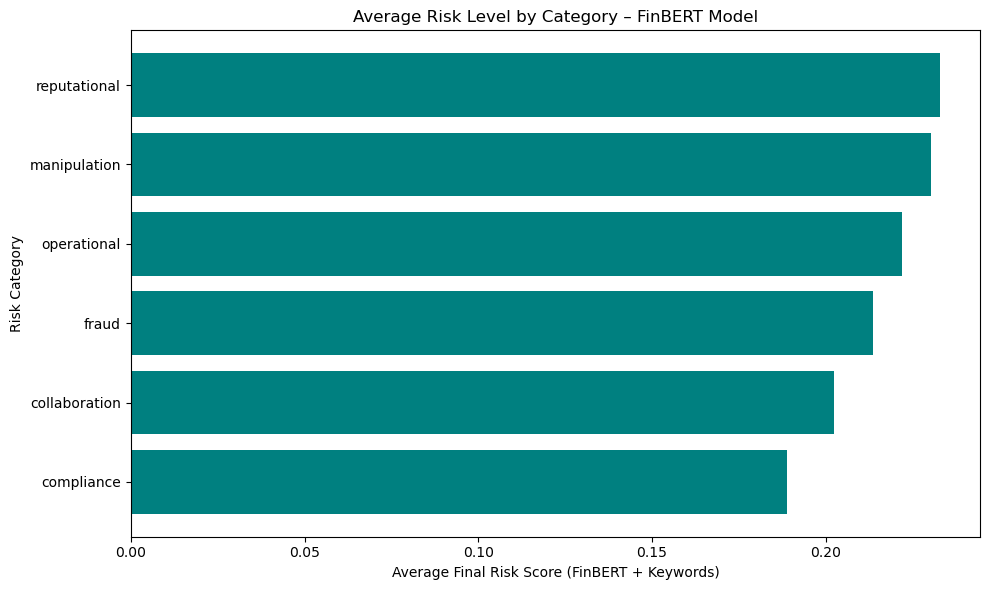

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

enhanced = pd.read_parquet("EnhancedRiskScores.parquet")

cat_summary = (
    enhanced.groupby("risk_category")
    .agg(avg_score=("final_score", "mean"),
         avg_model_conf=("model_conf", "mean"),
         total_emails=("email_id", "count"))
    .reset_index()
    .sort_values("avg_score", ascending=False)
)

plt.figure(figsize=(10,6))
plt.barh(cat_summary["risk_category"], cat_summary["avg_score"], color="teal")
plt.xlabel("Average Final Risk Score (FinBERT + Keywords)")
plt.ylabel("Risk Category")
plt.title("Average Risk Level by Category – FinBERT Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


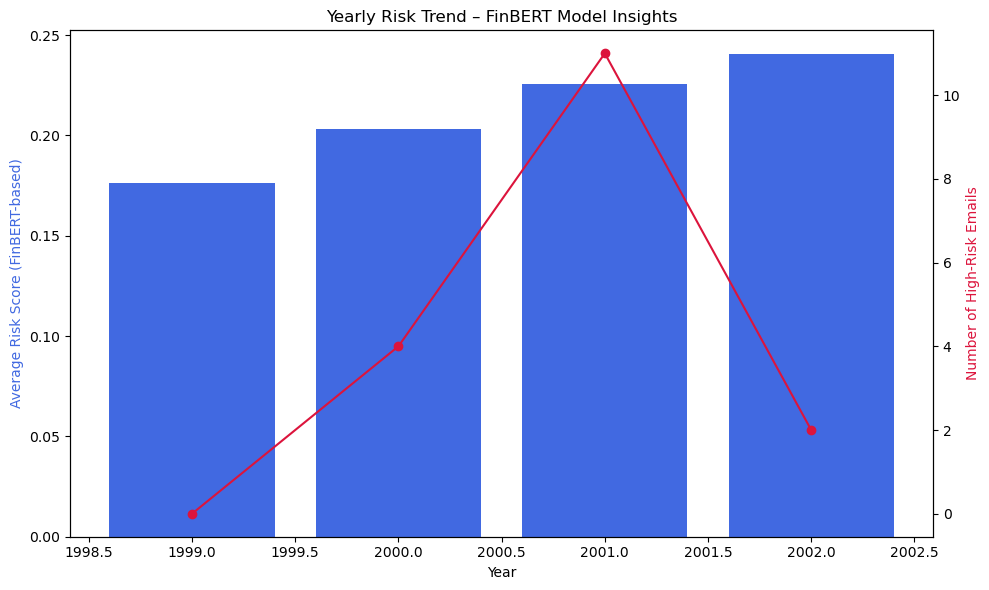

In [65]:
emails = pd.read_parquet(r"./Scripts\data_clean\Emails_clean_9902.parquet")

merged = enhanced.merge(emails[["email_id", "year"]], on="email_id", how="left")

year_summary = (
    merged.groupby("year")
    .agg(
        avg_risk=("final_score", "mean"),
        high_risk_count=("final_score", lambda x: (x > 0.9).sum())
    )
    .reset_index()
    .sort_values("year")
)

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

ax1.bar(year_summary["year"], year_summary["avg_risk"], color="royalblue", label="Average Risk Score")
ax2.plot(year_summary["year"], year_summary["high_risk_count"], color="crimson", marker="o", label="High-Risk Email Count")

ax1.set_xlabel("Year")
ax1.set_ylabel("Average Risk Score (FinBERT-based)", color="royalblue")
ax2.set_ylabel("Number of High-Risk Emails", color="crimson")
plt.title("Yearly Risk Trend – FinBERT Model Insights")
fig.tight_layout()
plt.show()


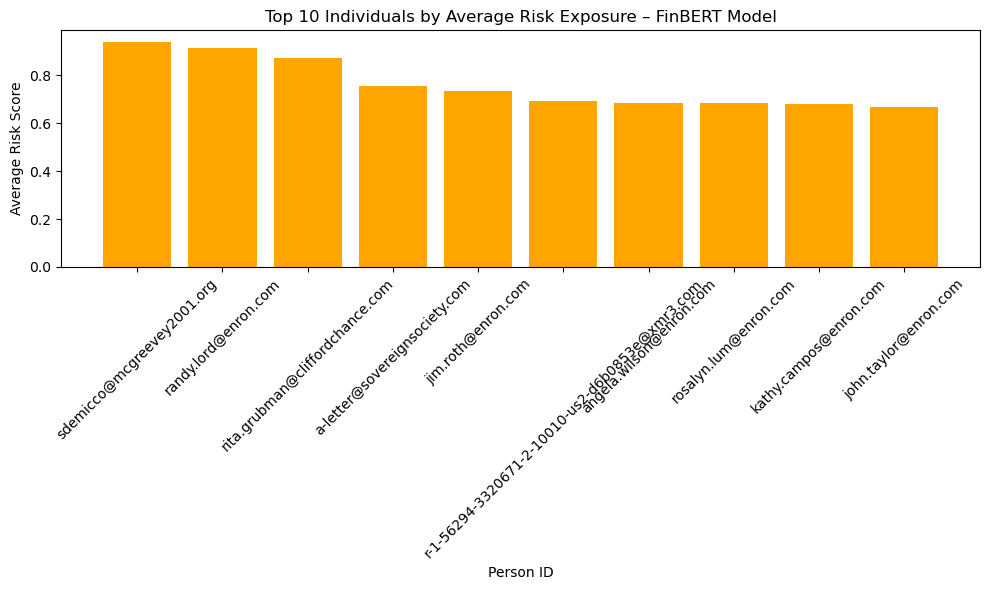

In [67]:
top_senders = (
    enhanced.groupby("email_id")
    .agg(max_score=("final_score","max"))
    .reset_index()
    .merge(emails[["email_id","person_id"]], on="email_id", how="left")
)

person_summary = (
    top_senders.groupby("person_id")
    .agg(avg_risk=("max_score","mean"))
    .sort_values("avg_risk", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
plt.bar(person_summary.index.astype(str), person_summary["avg_risk"], color="orange")
plt.xlabel("Person ID")
plt.ylabel("Average Risk Score")
plt.title("Top 10 Individuals by Average Risk Exposure – FinBERT Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
